A1.6 Regresión no lineal

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import statsmodels.api as sm

1. Se guarda en la variable data los datos del archivo csv "A1.6 Tiempo de Entrega". Es necesario hacer una conversión de los valores de la columna Calificacion y Tiempo, dado a que algunas entradas en el archivo original no son completamente numéricos al poner strings, signos especiales o valores nulos, igualmente, se eliminan columnas en donde hay valores nulos.

      Tiempo  Calificacion
0  85.076389          85.0
1  84.675556          85.0
2  79.553889         110.0
3  75.310556         110.0
4  64.958611         110.0
5  58.157778         110.0
6  56.238611         110.0
7  55.903056         110.0
8  52.465556         103.0
9  51.998333          96.0
lower bound:  -15.533888886875003
upper bound:  30.845555552125003


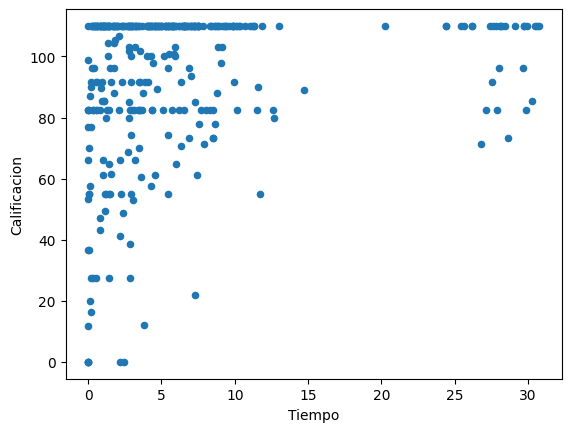

In [97]:
data = pd.read_csv("A1.6 Tiempo de Entrega Editado.csv")
print(data.head(10))

data_cleaned = data.dropna(subset=['Tiempo','Calificacion'])

# Why should the Tukey method be used? It doesn't assume a nomral distribution of data. It is effective for data with with heavy tails.
Q1 = data_cleaned["Tiempo"].quantile(0.25)
Q3 = data_cleaned["Tiempo"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

print("lower bound: ", lower_bound)
print("upper bound: ", upper_bound)

outliers = data_cleaned[ ( data_cleaned["Tiempo"] < lower_bound) | ( data_cleaned["Tiempo"] > upper_bound) ]
data_cleaned = data_cleaned[ ( data_cleaned["Tiempo"] >= lower_bound) & ( data_cleaned["Tiempo"] <= upper_bound) ]

data_cleaned.plot.scatter(x="Tiempo",y="Calificacion")
plt.show()

Se pudiera usar un algoritmo polinomial, ya sea cuadrático o cúbico, que logre capturar la tendencia de las calificaciones a aumentar entre más tiempo haya entre la fecha de entrega y la entrega del alumno de forma curveada y llegando a un máximo cuando la diferencia de tiempo es muy grande.

2. Se separan los datos de entrenamiento y de prueba en 70/30. Para los datos de entrenamiento y de prueba se imprimirán los valores promedios de calificación y tiepmo para la comparación de los dos grupos.

In [98]:
X = data_cleaned["Tiempo"]
Y = data_cleaned["Calificacion"]

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=.30)

print("Tiempo promedio de X_train: ", X_train.mean())
print("Calificacion promedio de Y_train: ", Y_train.mean())

print("Tiempo promedio de X_test: ", X_test.mean())
print("Calificacion promedio de Y_test: ", Y_test.mean())

Tiempo promedio de X_train:  5.972693877583673
Calificacion promedio de Y_train:  94.14544432653062
Tiempo promedio de X_test:  6.6772143606320755
Calificacion promedio de Y_test:  91.22861188679245


Los datos de entrenamiento y prueba de calificación y tiempo no difieren significativamente después de haber retirado el valor atípico mediante el método de Tukey, lo cual ayudara a que la variabilidad sea similar para el análisis.

3. Se entrena un modelo de regresión polinomial con los datos de entrenamiento. Se usa un orden de tres, ya que evita que el riesgo de sobreajuste con valores más altos mientras se asegura una mejor capacidad de reducción.

In [117]:
# Cubic polynomial

degree = 3
poly = PolynomialFeatures(degree)

X_train_poly = poly.fit_transform(X_train.to_frame())
X_test_poly = poly.transform(X_test.to_frame()) 
#print("X_train_poly: \n",X_train_poly)
#print("X_test_poly: \n",X_test_poly)

# What is the difference between fit and fit_transform? before applying transform, it also applies fit, which will generate all possible polynomial combinations of those features.
# It identifies the features and generates all possible combinations.
# It is important for understanding the structure of the data.

# What does transform do? It transforms input data into polynomial features based on the degree. It transforms single feature into polynomial features.

# Training the model
model = LinearRegression()
model.fit(X_train_poly, Y_train)

# Make predictions
Y_train_pred = model.predict(X_train_poly)
# Y_test_pred = model.predict(X_test_poly)  In here, Y_test original values are not used becuase they represent the true values.

# MSE and R2-sqared score
print("Train MSE:", mean_squared_error(Y_train, Y_train_pred))

r2 = r2_score(Y_train, Y_train_pred)
print("Train R²:", r2)

# Coefficients and the intercept
print("Coefficients: ", model.coef_)
print("Intercept: ", model.intercept_)

# Train Adjusted R-squared
n = len(Y_train)
p = len(model.coef_)
r2_adj = 1 - (1-r2)*(n-1)/(n-p-1)
print(" Test model R-adjusted-squared: ", r2_adj)

# Standard errors, t-values and p-values. DONE WITH TRAIN.
X_poly_sm = sm.add_constant(X_train_poly)
model_sm = sm.OLS(Y_train, X_poly_sm).fit()

print(model_sm.summary())
print(model_sm.pvalues)

# A big value of the TSS, indicates higher variability. A higher value of RSS indicates poor capacity prediction.
# RSE = MSE / n, n = number of observations.
RSE_poly = np.sqrt(np.sum((Y_train - Y_train_pred) ** 2))  


Train MSE: 507.4703494998893
Train R²: 0.08574936763826058
Coefficients:  [ 0.          4.86137501 -0.34842134  0.00705112]
Intercept:  81.69329781808773
 Test model R-adjusted-squared:  0.07051185709889829
                            OLS Regression Results                            
Dep. Variable:           Calificacion   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     7.535
Date:                Mon, 17 Feb 2025   Prob (F-statistic):           7.71e-05
Time:                        15:43:15   Log-Likelihood:                -1110.7
No. Observations:                 245   AIC:                             2229.
Df Residuals:                     241   BIC:                             2243.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
   

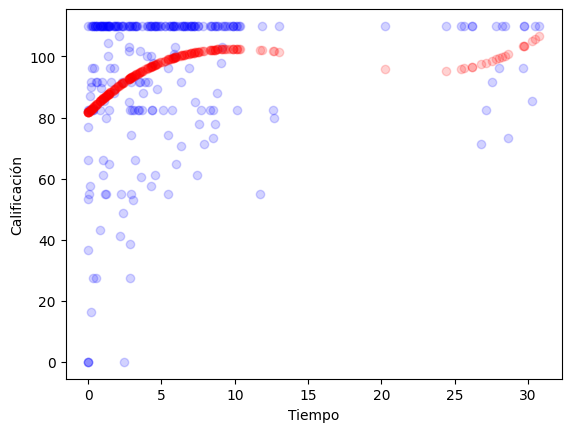

Punto crítico: 10.0303302896066, Tipo: Máximo local
Punto crítico: 22.9120798801183, Tipo: Mínimo local


In [100]:
plt.scatter(X_train,Y_train, color="blue", label="Puntos de datos",alpha=0.175)
plt.scatter(X_train, Y_train_pred,color="red",label="Modelo Polinomial Cúbico",alpha=0.175)
plt.xlabel("Tiempo")
plt.ylabel("Calificación")
plt.show()

import sympy as sp
x = sp.symbols('x')
f = model.coef_[3]*x**3 + model.coef_[2]*x**2 + model.coef_[1]*x + model.coef_[0]
f_prime = sp.diff(f, x)

critical_points = sp.solve(f_prime, x)

f_double_prime = sp.diff(f_prime, x)

critical_points_analysis = []
for point in critical_points:
    second_derivative_value = f_double_prime.subs(x, point)
    if second_derivative_value > 0:
        critical_points_analysis.append((point, 'Mínimo local'))
    elif second_derivative_value < 0:
        critical_points_analysis.append((point, 'Máximo local'))
    else:
        critical_points_analysis.append((point, 'Punto de silla'))

for point, nature in critical_points_analysis:
    print(f"Punto crítico: {point}, Tipo: {nature}")


A través de los datos anteriores, se puede concluir que el modelo no explica muy bien la variabilidad de los datos (R<sup>2</sup> ajustado = 0.141) y el MSE es alto (MSE = 505.99), lo que indica que los valores predecidos están muy alejados de los datos verdaderos para que nuestro modelo pueda capturar los patrones de los datos. El predictor X3 y X1 muestran una relación positiva, mientras que el predictor X2 muestra una relación negativa, de tal forma que las calificaciones aumentan hasta las 9.71 horas, después de ahí se va reduciendo la calificación hasta las 23.07 horas, en donde las calificaciones vuelven a mostrar un incremento.

Todas los predictores tienen asociaciones estadísticamente significativas, es decir, que tienen valores t mayores que 1.96 si son positivos o menores que -1.96 si son negativos. Los valores p son todos menores a 0.05.

4. A continuación, se realizará un modelo de regresión segmentada, utilizando en cada segmento, regresiones cuadráticas. El punto de quiebre que se seleccionará será 20, ya que los datos parecen alejarse a partir de este punto.

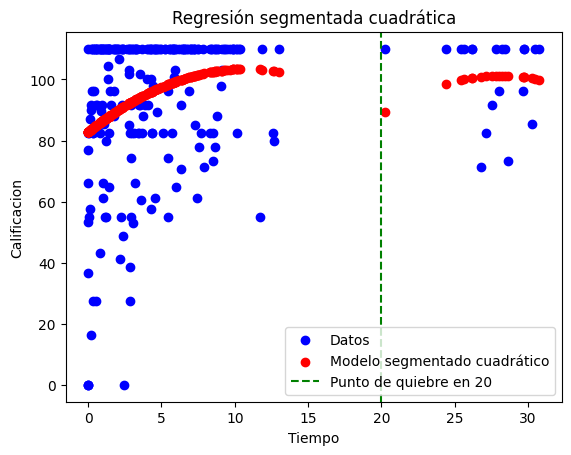

In [ ]:
X_np = X_train.values.reshape(-1, 1)

knot = 20

X_transformed = np.hstack([
    X_np,  # Original feature (Tiempo)
    X_np**2,  # Quadratic term for the first segment
    np.maximum(0, X_np - knot),  # Linear term for the second segment
    np.maximum(0, X_np - knot)**2  # Quadratic term for the second segment
])

X_transformed = X_transformed.reshape(-1, 4)  # 4 columns (4 features)

model = LinearRegression()
model.fit(X_transformed, Y_train)

Y_pred_segmented = model.predict(X_transformed)

plt.scatter(X_np, Y_train, color='blue', label='Datos')
plt.scatter(X_np, Y_pred_segmented, color='red', label='Modelo segmentado cuadrático')
plt.axvline(x=knot, color='green', linestyle='--', label='Punto de quiebre en 20')
plt.xlabel('Tiempo')
plt.ylabel('Calificacion')
plt.title('Regresión segmentada cuadrática')
plt.legend()
plt.show()

RSE_segmented = np.sqrt(np.sum((Y_train - Y_pred_segmented) ** 2))

5. Ahora, se trabajará con un modelo KNN con los datos para demostrar su capacidad de predicción. Se generarán las estimaciones con los datos de validación.

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

X_train_knn = X_train.values.reshape(-1, 1)
Y_train_knn = Y_train.values.reshape(-1, 1)
X_test_knn = X_test.values.reshape(-1, 1)

model_knn = KNeighborsRegressor(n_neighbors=5)
model_knn.fit(X_train_knn, Y_train_knn)
Y_pred_knn = model_knn.predict(X_train_knn) # WEIRD
RSE_knn = np.sqrt(np.sum((Y_train_knn - Y_pred_knn) ** 2))

6. Cálculo de RSE en los datos para el modelo polinomial cúbico, el de regresión segmentada cuadrática y KNN.

In [129]:
print(f"RSE de regresión cúbica: {RSE_poly}")
print(f"RSE de regresión segmentada cuadrática: {RSE_segmented}")
print(f"RSE de modelo KNN: {RSE_knn}")

RSE de regresión cúbica: 352.604928535426
RSE de regresión segmentada cuadrática: 353.64553802697475
RSE de modelo KNN: 304.40644858404636


7. Gráfico de la capacidad de predicciones con respecto a los valores reales de los tres modelos.

Las diferencias más notables son:

Código de honor: Doy mi palabra de que he realizado esta actividad con integridad académica.